## Multi-modal RAG for Medical Domain

In the rapidly evolving medical domain, professionals face significant challenges in data management due to the complexity of the data, the high level of expertise required, and concerns over data security (data protection regulations) and privacy. These challenges often hinder the efficiency of medical research and healthcare service delivery.

To address these issues, we propose the development of a Multi-Modal RAG (Retrieval-Augmented Generation) application. This cookbook aims to leverage a proven framework to enhance system robustness, privacy, and security through the integration of advanced technologies. Key technologies include a Multi-Modal Vector Database, RAG, and Large Language Models (LLMs), which are essential for simplifying the data preparation process, enhancing the integration of multimodal data, and facilitating the effective use of accumulated knowledge, even in offline environments.

This project is driven by the need to reduce the dependency on extensive expert involvement, which often acts as a significant bottleneck in the medical field. By automating and streamlining data queries and responses, the Multi-Modal RAG application will empower medical professionals and researchers to make faster, more informed decisions. Moreover, ensuring data security and privacy is crucial for maintaining the integrity and confidentiality of sensitive medical information, thus fostering trust and compliance with global data protection regulations such as HIPAA and GDPR.

Ultimately, this cookbook aims to create a Multi-Modal RAG application tailored for the medical domain that not only meets the technical and operational needs of the medical community but also addresses the broader challenges of accessibility, security, and efficiency in medical data management.

Many datasets in the medical domain contain a mixture of modalities, including text and images, yet the information captured from these modalities is not efficiently used in most existing RAG applications for decision support systems that aid medical diagnosis.

With the emergence of multimodal LLMs and vector databases, it is timely to consider how to utilize multi-modal data effectively in RAG applications.

This cookbook will highlight:

* The use of Unstructured Multi-Modal Datasets.
* The application of multimodal embeddings, such as CLIP, to embed images and text.
* The use of VDMS as a vector store with support for multi-modal data.
* The retrieval of both images and text using similarity search.
* The processing of raw images and text chunks through a multimodal LLM for answer synthesis.


## Packages

In [ ]:
# (newest versions required for multi-modal)
! pip install --quiet -U vdms langchain-experimental
! pip install --quiet pandas open_clip_torch torch wget docx2txt Image openpyxl

## Start VDMS Server

Let's start a VDMS docker using port 55559 instead of default 55555. 
Keep note of the port and hostname as this is needed for the vector store as it uses the VDMS Python client to connect to the server.

In [ ]:
! docker run --rm -d -p 55559:55555 --name vdms_rag_nb intellabs/vdms:latest

# Connect to VDMS Vector Store
from langchain_community.vectorstores.vdms import VDMS_Client

vdms_client = VDMS_Client(port=55559)

## Datasets

Breast cancer is a widespread malignancy affecting women worldwide. This cookbook has been developed using a [dataset](https://www.cancerimagingarchive.net/collection/cdd-cesm/) that consists of 2,006 high-resolution contrast-enhanced spectral mammography (CESM) images and radiologists' notes from 326 female patients. Only the subtracted images and the corresponding notes from experienced radiologists were used as inputs for the Multi-Modal RAG

![A sample of low energy and subtracted CESM images and Medical report, written by radiologists from the dataset. (Khaled, 2022)](https://github.com/intel/disease-prediction/raw/main/assets/cesm_and_annotation.png)

A sample of low energy and subtracted CESM images and Medical report, written by radiologists from the dataset. [(Khaled, 2022)](https://www.nature.com/articles/s41597-022-01238-0)

### Download and Preprocess the Datasets

Use the links below to download the image datasets. 

- [High-resolution Contrast-enhanced spectral mammography (CESM) images](https://www.cancerimagingarchive.net/collection/cdd-cesm/)


Once you've downloaded the image file, which will be in ZIP format, specify the location of the ZIP file as follows:

In [2]:
import os
root_folder = os.path.abspath('./')
downloaded_zip_file = os.path.join(root_folder, "CDD-CESM.zip") 

In [3]:
import zipfile
import wget
import shutil
import logging
import pandas as pd
import docx2txt
from PIL import Image

from pathlib import Path

def download_and_read_excel(url, filename="manual_annotations.xlsx"):
    """Downloads an Excel file from a URL and reads it into a DataFrame. Returns the DataFrame."""    
    if os.path.isfile(filename):
        os.remove(filename)
    wget.download(url, filename)
    
    try:
        return pd.read_excel(filename, sheet_name="all")
    except Exception as e:
        logging.error(f"Failed to read {filename} as an Excel file: {e}")
        return None

def download_and_extract(url, target_dir):
    """Downloads a zip file from a URL and extracts it to a target directory."""
    filename = wget.download(url)
    Path(target_dir).mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall("temp_folder")

    temp = zipfile.ZipFile(filename).infolist()[0]
    folder_name = Path("temp_folder") / temp.filename.split('/')[0]

    for file in folder_name.glob('*.docx'):
        if "~" not in file.name:
            shutil.copyfile(file, Path(target_dir) / file.name)
        
    os.remove(filename)
    shutil.rmtree("temp_folder")
    
    
def read_right_and_left(tx):
    tx_right, tx_left = "", ""
    if "Right Breast:" in tx and "Left Breast:" in tx:
        tx = tx.split("Left Breast:")
        tx_right = [
            i
            for i in tx[0].split("Right Breast:")[1].splitlines()
            if ("ACR C:" not in i and i != "")
        ]
        tx_left = [i for i in tx[1].splitlines() if ("ACR C:" not in i and i != "")]
    
    elif "Right Breast:" in tx and "Left Breast:" not in tx:
        tx = tx.split("Right Breast:")[1].splitlines()
        tx_right = [i for i in tx if i != ""]

    elif "Right Breast:" not in tx and "Left Breast:" in tx:
        tx = tx.split("Left Breast:")[1].splitlines()
        tx_left = [i for i in tx if i != ""]

    return tx_right, tx_left

def read_content(file_content):
    annotation = file_content.split("OPINION:")  
    mm_revealed = annotation[0].split("REVEALED:")[1]
    mm_revealed_right, mm_revealed_left = read_right_and_left(mm_revealed)
    optinion = annotation[1].split("CONTRAST ENHANCED SPECTRAL MAMMOGRAPHY REVEALED:")
    ces_mm_revealed = optinion[1]
    optinion = optinion[0]
    optinion_right, optinion_left = read_right_and_left(optinion)
    ces_mm_revealed_right, ces_mm_revealed_left = read_right_and_left(ces_mm_revealed)
    return mm_revealed_right, mm_revealed_left, optinion_right, optinion_left, ces_mm_revealed_right, ces_mm_revealed_left

def add_df_log(df, dict_text, manual_annotations, f_id, file_path):
    for side in manual_annotations.Side.unique():
        for mm_type in manual_annotations.Type.unique().tolist() + ["OP"]:
            text_list = dict_text[mm_type + "_" + side]
            df_temp = manual_annotations[(manual_annotations.Patient_ID == int(f_id)) & (manual_annotations.Side == side) & (manual_annotations.Type == mm_type)]
            image_name = df_temp.Image_name.tolist()            
            label = [None] if mm_type == "OP" else df_temp["Pathology Classification/ Follow up"].unique().tolist()
            if len(label) == 1:
                df.loc[len(df)] = [f_id, image_name, side, mm_type, label[0], " ".join(text_list), file_path]
    return df

def label_correction(df, label_column = "label", data_column = "symptoms", patient_id = "Patient_ID", file_path = "file_path"):
    df_new = pd.DataFrame(columns=[label_column, data_column, patient_id, file_path])
    for i in df[patient_id].unique():
        annotation = " ".join(df[df[patient_id].isin([i])][data_column].to_list())
        temp_labels = [label_indx for label_indx in df[df[patient_id] == i][label_column].unique() if label_indx is not None]
        file_path_i = df[df[patient_id].isin([i])][file_path].unique().tolist()[0]
        if len(temp_labels) == 1:
            df_new.loc[len(df_new)] = [temp_labels[0], annotation, i, file_path_i]
        elif len(temp_labels) > 1:
            df_temp = df[df[patient_id].isin([i])]
            if "CESM" in df_temp.Type.to_list():
                new_label = df_temp[df_temp.Type == "CESM"].label.to_list()[0]
                df_new.loc[len(df_new)] = [new_label, annotation, i, file_path_i]
        else:
            pass
    return df_new

def prepare_data(target_folder, manual_annotations):
    df = pd.DataFrame(columns=["ID", "Image", "Side", "Type", "label", "symptoms", "file_path"])
    for f in os.listdir(target_folder):
        DM_R, DM_L, OP_R, OP_L, CESM_R, CESM_L = "", "", "", "", "", ""
        f_id = f.split(".docx")[0].split("P")[1]
        file_path = os.path.join(target_folder, f)
        try:
            file_content = docx2txt.process(file_path)
        except Exception as e:
            Warning(e)
        DM_R, DM_L, OP_R, OP_L, CESM_R, CESM_L = read_content(file_content)
        dict_text = {"DM_R": DM_R, "DM_L": DM_L, "OP_R": OP_R, "OP_L": OP_L, "CESM_R": CESM_R, "CESM_L": CESM_L}
        df = add_df_log(df, dict_text, manual_annotations, f_id, file_path)
    df["Patient_ID"] = ["".join([str(df.loc[i, "ID"]), df.loc[i, "Side"]]) for i in df.index]
    df = label_correction(df)
    return df

def add_image_path_to_df(df, subtracted_image_path):
    img_dict = {}
    for images in os.listdir(subtracted_image_path):
        if images.endswith(".jpg"):
            image_path = os.path.join(subtracted_image_path, images)        
            pid = images.split("_")[0]
            sd = images.split("_")[1]
            patient_id =  pid[1:]+sd
            if patient_id not in img_dict:
                img_dict[patient_id] = []
            img_dict[patient_id].append(image_path)
    df_dict_list = df.to_dict(orient='records')  
    for i in range(len(df_dict_list)):
        patient_id = df_dict_list[i]['Patient_ID']
        df_dict_list[i]['images'] = img_dict[patient_id]
    return pd.DataFrame(df_dict_list)

def resize_images_in_folder(folder_path, output_folder_path, size=(256, 256)):
    """Resize all images in a folder to the specified size and save them in the output folder."""
    Path(output_folder_path).mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img = Image.open(os.path.join(folder_path, filename))
            img_resized = img.resize(size)
            img_resized.save(os.path.join(output_folder_path, filename))

def clean_temp_files_and_folders():
    shutil.rmtree("Medical_reports_for_cases")
    shutil.rmtree("CDD-CESM")
    os.remove("manual_annotations.xlsx")

def create_brca_data(downloaded_zip_file, test_subjects):
    with zipfile.ZipFile(downloaded_zip_file, "r") as zip_ref:
        zip_ref.extractall()
        
    annotation_file_url = "https://www.cancerimagingarchive.net/wp-content/uploads/Radiology-manual-annotations.xlsx"
    manual_annotations = download_and_read_excel(annotation_file_url)
    web_url = "https://www.cancerimagingarchive.net/wp-content/uploads/Medical-reports-for-cases-.zip"
    target_folder = "Medical_reports_for_cases"
    download_and_extract(web_url, target_folder)
    df = prepare_data(target_folder, manual_annotations)
    subtracted_image_path = os.path.join(root_folder, "CDD-CESM", "Subtracted images of CDD-CESM")    
    resized_img_folder = os.path.join(root_folder, "resized_subtracted_images_of_CDD_CESM" )            
    resize_images_in_folder(subtracted_image_path, resized_img_folder )
    df = add_image_path_to_df(df, resized_img_folder)
    clean_temp_files_and_folders()
    
    # The dataset has been updated to exclude Image 119L. This image will now be specifically employed to evaluate the 
    # performance capabilities of the MM-RAG system
    df_test = df[df.Patient_ID.isin(test_subjects)]
    df_rag = df[~df.Patient_ID.isin(test_subjects)]
    
    return df_rag, df_test

df_rag, df_test = create_brca_data(downloaded_zip_file, test_subjects = ["119L"])

print("df_rag:", df_rag.shape)
print("df_test:", df_test.shape)

df_rag: (563, 5)
df_test: (1, 5)


## Multi-modal embeddings with our document

We will use [OpenClip multimodal embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

We use a larger model for better performance (set in `langchain_experimental.open_clip.py`).

```
model_name = "ViT-B-16-plus-240"
checkpoint = "laion400m_e32"
```

`vectorstore.add_images` will store / retrieve images as base64 encoded strings.

In [4]:
from langchain_community.vectorstores import VDMS
from langchain_experimental.open_clip import OpenCLIPEmbeddings

In [ ]:
# Create VDMS
vectorstore = VDMS(
    client=vdms_client,
    collection_name="mm_rag_medical",
    embedding=OpenCLIPEmbeddings(model_name="ViT-B-16-plus-240", checkpoint="laion400m_e32"),
    engine="FaissFlat",
    distance_strategy="L2"
    )

def add_text_and_image_to_vectorstore(df_brca, vectorstore):    
    for i in df_brca.index:
        meta_data = {}
        for img in df_brca.images[i]:
            encode_image = vectorstore.encode_image(img) 
            meta_data["Patient_ID"] = df_brca.Patient_ID[i]
            if "MLO" in img:
                meta_data["mlo"] = encode_image 
            elif "CC" in img:
                meta_data["cc"] = encode_image 
            else:
                ValueError("Unknown Image type found") 
                
            # adding images  
            vectorstore.add_images(uris=[img], metadatas=[{"symptoms":df_brca.symptoms[i], "Patient_ID":df_brca.Patient_ID[i]}])
        
    return vectorstore

# Adding text and images to the vector store
vectorstore = add_text_and_image_to_vectorstore(df_rag, vectorstore)

# Make retriever
retriever = vectorstore.as_retriever()

## RAG

In [17]:
from IPython.display import HTML, display
import base64
from io import BytesIO

def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []

    for doc in docs:
        if is_base64(doc.page_content):
            images.append(doc.page_content)              
            for k,v in doc.metadata.items():                
                if k == 'symptoms': 
                    text.append(v)
        else:
            text.append(doc.page_content)
            for k,v in doc.metadata.items():
                if k != 'Patient_ID' and is_base64(v):
                    images.append(v)
                    
    return {"images": images, "texts": text}

def preprocess_query(data_dict):
    if "image" in data_dict.keys(): 
        return data_dict["image"]
    else:
        return data_dict["prompt"] 

Currently, we format the inputs using a `RunnableLambda`. 

Our runnable follows the classic RAG flow - 

* We first run preprocessing function to define prompt and image.
* Then compute the context ("images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the llava model. 
* And finally we parse the output as a string.

Here we are using Ollama to serve the Llava model. Please see [Ollama](https://python.langchain.com/docs/integrations/llms/ollama) for setup instructions.

In [6]:
from langchain_community.llms.ollama import Ollama
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

def image_message_func(img):
    return {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{img}"
        },
    }
            
def prompt_func(data_dict):
    messages = []
    
    # Joining the context texts into a single string
    formatted_texts = "\n".join( data_dict["context"]["texts"] )
    
    # Adding image(s) to the messages if present    
    embeded_images = image_message_func( vectorstore.encode_image( data_dict['question']["image"] ) )
    messages.append(embeded_images)
            
    text_message = {
    "type": "text",
    "text": (
        """
        As an medical expert, you will be provided a medical image. 
        Also, you will be provided medical expert's notes for similar images from vector store to offer the context.  
                
        As an assistant, you need to follow these Rules while answering questions,
        Rules:
        - Only use medical expert's notes when the task requires them to help answer the question."
        - Don't be toxic and don't include harmful information."
        
        The user wants to know,
        """
        f" USER: {data_dict['question']['prompt']} \n\n " 
        
        """
        Please use your extensive knowledge and analytical skills that includes:
        - A detailed description of the visual elements in the provided image.
        - Summary of your analysis and interpretation. "
        - Considering the recommendations for further evaluation or treatment as necessary for provided images.
        
        Medical expert's notes for similar images:"
        """
        f"{formatted_texts}"
        ),
    }
    
    messages.append(text_message)
        
    return [HumanMessage(content=messages)]

def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""

    # Multi-modal LLM
    llm_model = Ollama(
        verbose=True, 
        temperature=0.8, 
        model="llava", 
        base_url="http://localhost:11434",
    )

    # RAG pipeline
    chain = (        
        {   
            "context": RunnableLambda(preprocess_query) | retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough()
        }
        | RunnableLambda(prompt_func)
        | llm_model
        | StrOutputParser()
    )

    return chain


## Test retrieval

In [26]:
def display_image(p_id, df_brca):
    indx = df_brca[df_brca['Patient_ID'] == p_id].index.to_list()[0]
    print("Annotation of Radiologist: ", df_brca.symptoms[indx])    
    for image_path in df_brca.images[indx]:
        print(os.path.split(image_path)[1] )
        img = Image.open(image_path)
        display(img)        
    return df_brca.images[indx]

def vectorstore_retriever(query, retriever):
    docs = retriever.invoke(query, k=10)
    for doc in docs:
        if is_base64(doc.page_content):
            plt_img_base64( doc.page_content)             
        else:
            for k in doc.metadata.keys():
                if k in ["cc", "mlo"] and is_base64(doc.metadata[k]):
                    plt_img_base64(doc.metadata[k])
            

We will evaluate the performance of the MM-RAG by analyzing the following images. You will see both the CC (Cranio-Caudal) and MLO (Medio-Lateral Oblique) views of the mammogram scan, along with annotations from an expert radiologist. These elements are used to verify the accuracy of the MM-RAG

Annotation of Radiologist:  Upper outer retroareolar multiple irregular high density masses with indistinct margin and edema pattern are noted. No suspicious microcalcifications. Upper outer retroareolar multiple irregular heterogenously enhancing masses (BIRADS 5). Upper outer retroareolar suspicious looking asymmetry and edema pattern (BIRADS 4).
P119_L_CM_CC.jpg


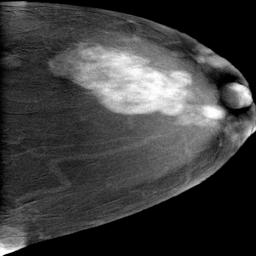

P119_L_CM_MLO.jpg


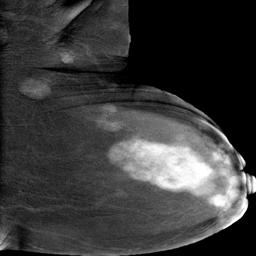

In [27]:
p_id = "119L"
img_paths = display_image(p_id, df_test)


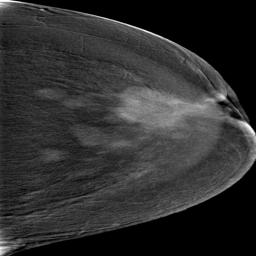


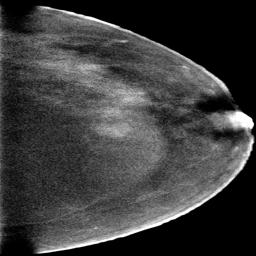


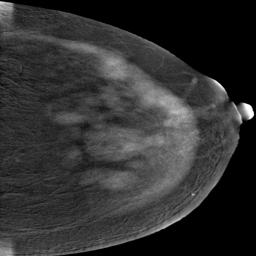

In [28]:
# We will use bilateral craniocaudal (CC) image (P119_L_CM_CC.jpg) for the evaluation
img_path = img_paths[0]

# test retrieval for finding similar images
vectorstore_retriever(img_path, retriever) 

## Run RAG
We introduce a query using only the CC image, without any accompanying notes from the radiologist

In [21]:
prompt = "what is this image about?"
query = {"prompt": prompt, "image": img_path}

chain = multi_modal_rag_chain(retriever)
response = chain.invoke(query)
HTML(response)